# Modèle de la production solaire Suisse

Ce modèle utilise :
- les installations solaires suisses (données SFOE/OFEN) avec leurs coordonnées géographiques
- les facteurs de production solaire par région NUTS2 (données dérivées de ERA5, voir https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.4bd77450)

Il permet de calculer la production solaire Suisse totale et par région NUTS2.

### 1. Liste des installations solaires suisses

In [13]:
import pandas as pd

solar_plants = pd.read_csv('./data/CH_ElectricityProductionPlant_final.csv', parse_dates=True)
solar_plants = solar_plants[solar_plants['SubCategory'] == 'Solar_CH']

In [14]:
solar_plants.head()

,Unnamed: 0,xtf_id,Canton,BeginningOfOperation,InitialPower,TotalPower,SubCategory,PlantCategory,_x,_y,CumulativePower
406,168668,8556,AR,1988-07-20,3.0,3.0,Solar_CH,NaN,2751936.0,1247538.0,3.0
407,168636,8640,LU,1988-09-01,1.0,1.0,Solar_CH,NaN,2657727.0,1219823.0,4.0
412,169332,10086,BE,1989-01-01,1.2,1.2,Solar_CH,NaN,2573947.0,1210053.0,5.2
418,167249,227412,VS,1989-01-01,10.5,10.5,Solar_CH,NaN,NaN,NaN,15.7
421,166142,99661,SH,1989-07-01,23.8,23.8,Solar_CH,NaN,2688838.0,1284316.0,39.5


#### Mapping de leurs positions vers les régions NUTS niveau 2
Les coordonnées _x et _y sont au format MN95 (EPSG:2056) (système de coordonnées suisse) : on les convertit en degrés décimaux (EPSG:4326) (longitude/latitude GPS) pour pouvoir les classer dans les régions NUTS2.

In [15]:
from math import isnan
from shapely import Point
import geopandas as gpd
from pyproj import Transformer

# Définir la projection
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")  # MN95 -> WGS84

# Charger la carte NUTS2 dans geopandas
nuts2 = gpd.read_file("./data/NUTS_RG_01M_2021_4326_LEVL_2.geojson")
ch_nuts = nuts2[nuts2['CNTR_CODE'] == 'CH']

# Créer une colonne vide pour stocker le nom de la région
solar_plants['region'] = 'CH05'  # Valeur par défaut pour les installations sans coordonnées

# Boucler sur chaque paire de coordonnées MN95
for i in solar_plants.index:
    if isnan(solar_plants.loc[i, '_x']) or isnan(solar_plants.loc[i, '_y']):
        continue
    # Convertir les coordonnées en degrés décimaux
    lat, lon = transformer.transform(solar_plants.loc[i, '_x'], solar_plants.loc[i, '_y'])
    point = Point(lon, lat)

    # Trouver la région correspondante dans la carte NUTS2
    for index, row in ch_nuts.iterrows():
        if row.geometry.contains(point):
            solar_plants.loc[i, 'region'] = row.NUTS_ID
            break

# Afficher la liste de coordonnées classées par région
print(solar_plants.groupby('region').size())

region
CH01    32422
CH02    44207
CH03    18914
CH04    14881
CH05    34864
CH06    13817
CH07     8220
dtype: int64


#### Validation : puissances installées :

In [38]:
installed_power = solar_plants['TotalPower'].sum()
print('Puissance des panneaux installés au 30 Avril 2023 :', installed_power, 'kWc')

Puissance des panneaux installés au 30 Avril 2023 : 3836169.51 kWc


In [39]:
solar_plants_2021 = solar_plants[solar_plants['BeginningOfOperation'] < '2022-01-01']
installed_power_2021 = solar_plants_2021['TotalPower'].sum()
print('Puissance des panneaux installés avant 2022 :', installed_power_2021, 'kWc')

Puissance des panneaux installés avant 2022 : 3294074.09 kWc


In [40]:
solar_plants_2022 = solar_plants[solar_plants['BeginningOfOperation'] < '2023-01-01']
installed_power_2022 = solar_plants_2022['TotalPower'].sum()
print('Puissance des panneaux installés avant 2023 :', installed_power_2022, 'kWc')

Puissance des panneaux installés avant 2023 : 3805950.8999999994 kWc


In [41]:
diff_21_22 = solar_plants[solar_plants['BeginningOfOperation'] < '2022-01-01']['TotalPower'].sum() - \
             solar_plants[solar_plants['BeginningOfOperation'] < '2021-01-01']['TotalPower'].sum()
print('Puissance installée entre 2021 et 2022 : ', diff_21_22)

Puissance installée entre 2021 et 2022 :  511990.1699999999


In [42]:
ofen_data = {
    '2009-01-01': 45.3,
    '2010-01-01': 71.4,
    '2011-01-01': 125.4,
    '2012-01-01': 222.9,
    '2013-01-01': 436.6,
    '2014-01-01': 755.6,
    '2015-01-01': 1060.6,
    '2016-01-01': 1394.0,
    '2017-01-01': 1664.2,
    '2018-01-01': 1906.4,
    '2019-01-01': 2173.2,
    '2020-01-01': 2498.1,
    '2021-01-01': 2973.4,
    '2022-01-01': 3655.3
}
ofen_data = pd.DataFrame.from_dict(ofen_data, orient='index', columns=['installed_ofen'])
ofen_data.index = pd.to_datetime(ofen_data.index)
ofen_data = ofen_data.resample('M').max().interpolate(method='linear', limit_direction='forward')

In [43]:
by_date = solar_plants.groupby('BeginningOfOperation')['CumulativePower'].max()
by_date.index = pd.to_datetime(by_date.index)
by_date_c = by_date['2009-01-01':] / 1000
data_monthly = by_date_c.resample('M').max().fillna(method='ffill')

ofen_data['correction'] = 1
for m in ofen_data.index:
    ofen_data.loc[m, 'correction'] = data_monthly[m] / ofen_data.loc[m, 'installed_ofen']

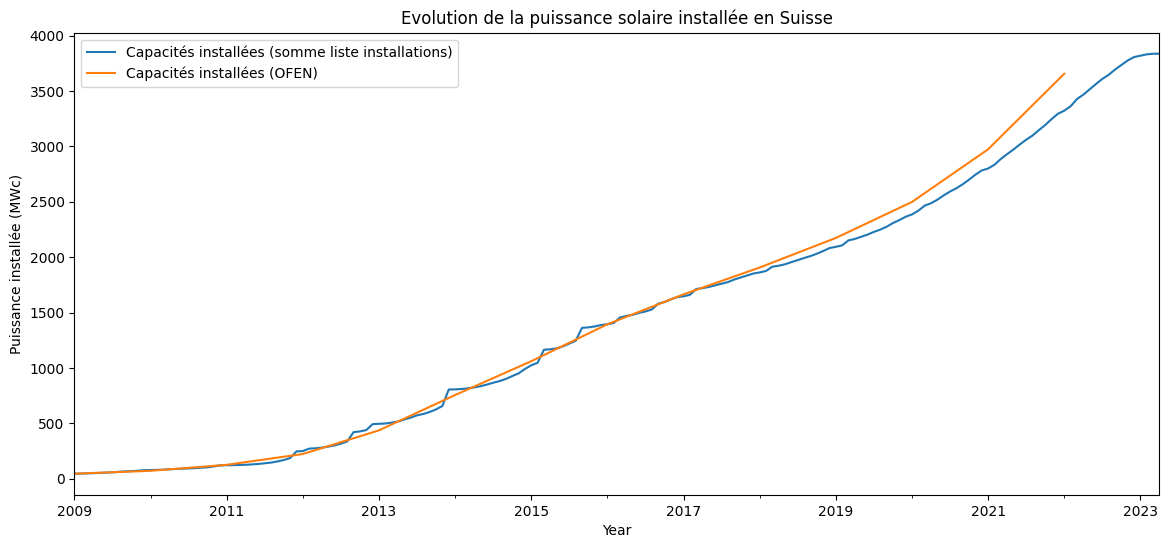

In [44]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))
data_monthly.plot(ax=ax, label='Capacités installées (somme liste installations)', legend=True)
ofen_data['installed_ofen'].plot(ax=ax, label='Capacités installées (OFEN)', legend=True)
ax.set_ylabel('Puissance installée (MWc)')
ax.set_xlabel('Year')
ax.set_title('Evolution de la puissance solaire installée en Suisse');

La puissance installée réelle est différente, par exemple en 2021 l'OFEN donne 3655.5 MWc installés, contre 3294.4 MWc dans notre modèle. On calcule alors un facteur de correction pour ajuster la puissance installée à la valeur réelle. Cela permet de conserver la répartition géographique des installations tout en ayant une puissance installée totale correcte.

todo interpréter 2022 + explications (cf doc word)

In [45]:
def fit_installed_power(solar_plants, theorical_installed_power):
    actual_installed_power = solar_plants['TotalPower'].sum()
    print('Correction factor:', actual_installed_power / theorical_installed_power)
    solar_plants2 = solar_plants.copy()
    solar_plants2['TotalPower'] *= theorical_installed_power / actual_installed_power
    return solar_plants2

In [46]:
solar_plants_2021_fitted = fit_installed_power(solar_plants_2021, 3655300)

Correction factor: 0.9011774929554345


### 2. Facteur de charge des panneaux solaires par région NUTS niveau 2

Les facteurs de charge sont issus des données ERA5 (voir https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.4bd77450) pour chaque région NUTS2.
On lit simplement le fichier csv les contenant.

In [47]:
solar_factor = pd.read_csv(
    './data/H_ERA5_ECMW_T639_SPV_0000m_Euro_NUT2_S197901010000_E202303312300_CFR_TIM_01h_NA-_noc_org_NA_NA---_NA---_PhM02.csv',
    skiprows=52,
    parse_dates=True,
    index_col='Date')

# le fichier contient tout l'Europe, on ne garde que la Suisse
solar_factor = solar_factor.drop(columns=[col for col in solar_factor.columns if not col.startswith('CH')])
solar_factor.fillna(0, inplace=True)

In [48]:
solar_factor = solar_factor.loc[:'2023-01-01 23:00:00'] # pbs d'index après

In [49]:
    theo_r_factor_1 = theo_MWh_yield / 8760
    theo_r_factor_2 = theo_year_prod / 8760 * 1000 / theo_installed_capacity  #theo_year_prod / 8760 * 1000 : puissance en pratique (GWc)

NameError: name 'theo_year_prod' is not defined

La production spécifique annuelle moyenne des installations raccordées au réseau à été incluse jusqu’au recensement
de 2009 dans la « Statistique courant solaire photovoltaïque » et tient compte depuis 2003 de l’ensoleillement de
l’année de recensement. Depuis le recensement du marché de 2010, une moyenne des installations photovoltaïques
avec rétribution à prix coûtant (RPC), de l’attestation du type de production et de l’origine de l’électricité (OAO), ainsi
que du financement des frais supplémentaires (FFS) est obtenue à partir de la base de données de Swissgrid.
La valeur moyenne se montait à 915 kWh/kWp en 2013 (2012 : 975 kWh/kWp)

In [50]:
ofen_yields_theo = {
    #'2009-01-01': 870,
    '2009-01-01': 860,
    '2010-01-01': 925,
    '2011-01-01': 1000,
    '2012-01-01': 975,
    '2013-01-01': 915,
    '2014-01-01': 995,
    '2015-01-01': 965,
    '2016-01-01': 905,
    '2017-01-01': 970,
    '2018-01-01': 980,
    '2019-01-01': 960,
    '2020-01-01': 985,
    '2021-01-01': 895
}
ofen_yields_theo = pd.DataFrame.from_dict(ofen_yields_theo, orient='index', columns=['theo_yield'])
ofen_yields_theo = ofen_yields_theo / 8760
ofen_yields_theo.index = pd.to_datetime(ofen_yields_theo.index)
ofen_yields_theo = ofen_yields_theo.resample('Y').mean().interpolate(method='pad', limit_direction='forward')

Text(0.5, 1.0, 'Evolution de %')

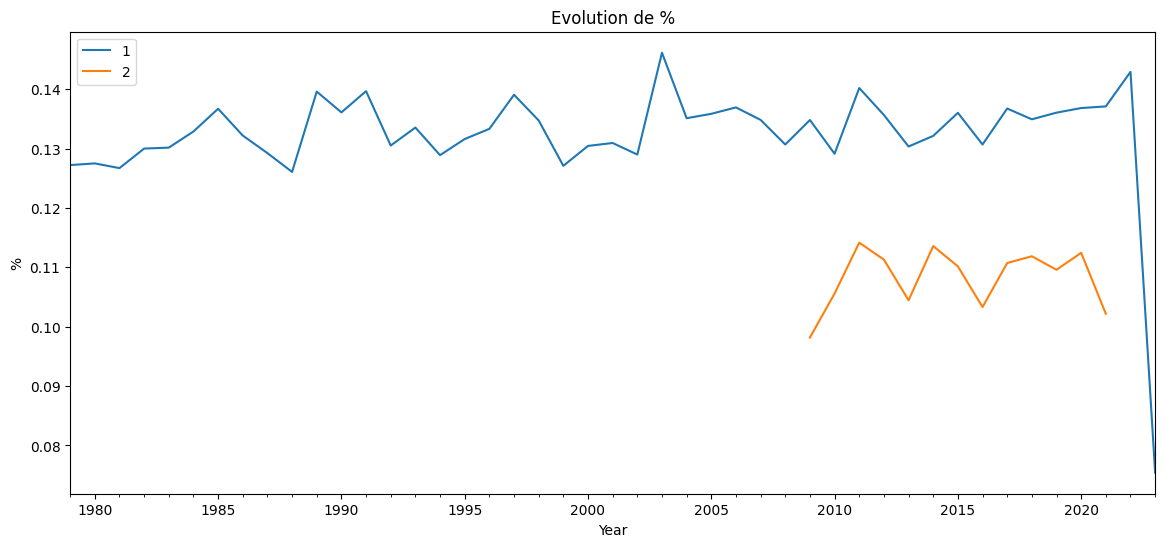

In [51]:
solar_factor.index = pd.to_datetime(solar_factor.index)
solar_factor_m = solar_factor.resample('Y').mean().mean(axis=1)

fig, ax = plt.subplots(figsize=(14, 6))
solar_factor_m.plot(ax=ax, label='1', legend=True)
ofen_yields_theo['theo_yield'].plot(ax=ax, label='2', legend=True)
ax.set_ylabel('%')
ax.set_xlabel('Year')
ax.set_title('Evolution de %')

### 3. Calcul de la production solaire suisse

#### 2021

#### v2

In [52]:
name_map = {
    'I.': 'Installed capacity (MWc)',
    '0.': 'Truth',
    '1.': 'CDS data yield',
    '2.1': 'Given OFEN yield - with scaled prod',
    '2.2': 'Given OFEN yield - with capa',
    '3.1': 'Practical OFEN yield - with scaled prod',
    '3.2': 'Practical OFEN yield - with capa',
    'R': 'R factor',
    'A': 'Yearly production with practical capacities (GWh)',
    'B': 'Yearly production with theoretical capacities (GWh)',
    'C': 'Yearly production with scaled capacities (GWh)'
}

def compute_yearly_solar_production(solar_plants, solar_factors, start, end, theo_installed_capacity, theo_year_prod,
                                    theo_MWh_yield, freq='D'):
    # Générer un DataFrame avec l'index des dates
    dates = pd.date_range(start=start, end=end, freq=freq)
    by_date = pd.DataFrame(index=dates)

    # Calculer la puissance cumulée pour chaque région
    regions = solar_plants['region'].unique()
    for region in regions:
        # Filtrer les installations pour la région donnée
        df_region = solar_plants[solar_plants['region'] == region]

        # Regrouper par date de début d'opération et calculer la somme de la puissance
        df_grouped = df_region.groupby('BeginningOfOperation')['TotalPower'].sum()
        df_grouped.index = pd.to_datetime(df_grouped.index)

        # Puissance installée au début de l'année
        base_value = df_grouped.loc[:start].sum()
        # Réindexer pour inclure toutes les dates entre d1 et d2
        df_grouped = df_grouped.reindex(dates, fill_value=0)
        df_grouped.loc[start] = base_value

        # Ajouter la colonne de puissance cumulée de la région au DataFrame de sortie
        by_date[region] = df_grouped.cumsum()
    by_date = by_date / 1000  # Convertir en MWc
    solar_factor_resampled = solar_factors.resample(freq).mean().loc[start:end]
    n_hours_freq = 24 if freq == 'D' else 1
    produced_year = solar_factor_resampled.multiply(by_date).sum(axis=1) * n_hours_freq
    produced_year = produced_year / 1000  # Convertir en GWh
    daily_capa = by_date.sum(axis=1) * n_hours_freq / 1000

    installed_capacity_end_year = by_date.iloc[-1].sum()
    theo_r_factor_1 = theo_MWh_yield / 8760
    theo_r_factor_2 = theo_year_prod / 8760 * 1000 / theo_installed_capacity  #theo_year_prod / 8760 * 1000 : puissance en pratique (GWc)
    practical_r_factor = solar_factors.mean().mean()
    results_frame = pd.DataFrame(
        index=['I.', '0.', '1.', '2.1', '2.2',
               '3.1', '3.2'],
        columns=['R', 'A',
                 'B',
                 'C'])
    results_frame.loc['I.', 'R'] = '-'
    results_frame.loc['I.', 'A'] = installed_capacity_end_year
    results_frame.loc['I.', 'B'] = theo_installed_capacity
    results_frame.loc['I.', 'C'] = theo_installed_capacity
    results_frame.loc['0.', 'R'] = '-'
    results_frame.loc['1.', 'R'] = practical_r_factor
    results_frame.loc['2.1', 'R'] = theo_r_factor_1
    results_frame.loc['2.2', 'R'] = ''
    results_frame.loc['3.1', 'R'] = theo_r_factor_2
    results_frame.loc['3.2', 'R'] = ''
    #print("===============================")
    #print("Official yearly production:", theo_year_prod, "GWh")

    #print("### Case 1: Using computed installed capacity of", installed_capacity_end_year, "MWc ###")
    total = produced_year.sum()
    results_frame.loc['0.', 'A'] = '-'
    #print("---> 1.1: With computed R factor equal to", practical_r_factor, ":", total, "GWh")
    results_frame.loc['1.', 'A'] = total
    #print("---> 1.2a: With theoretical R factor 1 equal to", theo_r_factor_1, "(prod scaled) :",
    #      theo_r_factor_1 / practical_r_factor * total, "GWh")
    results_frame.loc[
        '2.1', 'A'] = theo_r_factor_1 / practical_r_factor * total
   # print("---> 1.2b: With theoretical R factor 1 equal to", theo_r_factor_1, "(capa) :",
   #       (daily_capa * theo_r_factor_1).sum(), "GWh")
    results_frame.loc['2.2', 'A'] = (
            daily_capa * theo_r_factor_1).sum()
   # print("---> 1.3a: With theoretical R factor 2 equal to", theo_r_factor_2, "(prod scaled) :",
   #       theo_r_factor_2 / practical_r_factor * total, "GWh")
    results_frame.loc[
        '3.1', 'A'] = theo_r_factor_2 / practical_r_factor * total
  #  print("---> 1.3b: With theoretical R factor 2 equal to", theo_r_factor_2, "(capa) :",
  #        (daily_capa * theo_r_factor_2).sum(), "GWh")
    results_frame.loc['3.2', 'A'] = (
            daily_capa * theo_r_factor_2).sum()

  #  print("### Case 2: Using theoretical installed capacity of", theo_installed_capacity, "MWc ###")
    results_frame.loc['0.', 'B'] = theo_year_prod
    results_frame.loc['1.', 'B'] = '-'
  #  print("----> 2.1: With theoretical R factor 1 equal to", theo_r_factor_1, ":",
  #        theo_r_factor_1 * theo_installed_capacity * 8760, "GWh")
    results_frame.loc['2.1', 'B'] = '-'
    results_frame.loc[
        '2.2', 'B'] = theo_r_factor_1 * theo_installed_capacity * 8760 / 1000
    # TODO CALCUL AVEC 50% CAPA AJOUTEE L'ANNEE X (cf méthode OFEN)
  #  print("----> 2.2: With theoretical R factor 2 equal to", theo_r_factor_2, ":",
 #         theo_r_factor_2 * theo_installed_capacity * 8760, "GWh")
    results_frame.loc['3.1', 'B'] = '-'
    results_frame.loc[
        '3.2', 'B'] = theo_r_factor_2 * theo_installed_capacity * 8760 / 1000

#    print("### Case 3: Using scaled installed capacity to", theo_installed_capacity, "MWc ###")
    theo_capacity_correction_factor = theo_installed_capacity / installed_capacity_end_year
  #  print("Correction factor is:", theo_capacity_correction_factor)
    total = produced_year.sum() * theo_capacity_correction_factor
    daily_capa = daily_capa * theo_capacity_correction_factor
    results_frame.loc['0.', 'C'] = theo_year_prod
  #  print("---> 3.1: With computed R factor equal to", practical_r_factor, ":", total, "GWh")
    results_frame.loc['1.', 'C'] = total
  #  print("---> 3.2a: With theoretical R factor 1 equal to", theo_r_factor_1, "(prod scaled) :",
  #        theo_r_factor_1 / practical_r_factor * total, "GWh")
    results_frame.loc[
        '2.1', 'C'] = theo_r_factor_1 / practical_r_factor * total
  #  print("---> 3.2b: With theoretical R factor 1 equal to", theo_r_factor_1, "(capa) :",
  #        (daily_capa * theo_r_factor_1).sum(), "GWh")
    results_frame.loc['2.2', 'C'] = (
            daily_capa * theo_r_factor_1).sum()
  #  print("---> 3.3a: With theoretical R factor 2 equal to", theo_r_factor_2, "(prod scaled) :",
  #        theo_r_factor_2 / practical_r_factor * total, "GWh")
    results_frame.loc[
        '3.1', 'C'] = theo_r_factor_2 / practical_r_factor * total
  #  print("---> 3.3b: With theoretical R factor 2 equal to", theo_r_factor_2, "(capa) :",
  #        (daily_capa * theo_r_factor_2).sum(), "GWh")
    results_frame.loc['3.2', 'C'] = (
            daily_capa * theo_r_factor_2).sum()

    results_frame.rename(index=name_map, inplace=True)
    results_frame.rename(columns=name_map, inplace=True)
    return produced_year, results_frame, theo_r_factor_1, practical_r_factor, theo_capacity_correction_factor

In [53]:
theo_MWh_yield = 895 * (3648.7 / 3655.3) + 537 * (6.6 / 3655.3)
produced_year, results_frame, theo_r_factor_1, practical_r_factor, theo_capacity_correction_factor = compute_yearly_solar_production(
    solar_plants, solar_factor, '2021-01-01', '2021-12-31', 3655.3, 2842, theo_MWh_yield)
results_frame

,R factor,Yearly production with practical capacities (GWh),Yearly production with theoretical capacities (GWh),Yearly production with scaled capacities (GWh)
Installed capacity (MWc),-,3294.07409,3655.3,3655.3
Truth,-,-,2842,2842
CDS data yield,0.133546,3610.833662,-,4006.79521
Given OFEN yield - with scaled prod,0.102095,2760.464447,-,3063.175089
Given OFEN yield - with capa,,2700.878289,3269.1307,2997.054753
Practical OFEN yield - with scaled prod,0.088756,2399.793914,-,2662.953672
Practical OFEN yield - with capa,,2347.99303,2842.0,2605.472338


In [54]:
def format_results(x):
    if isinstance(x, str):
        return x
    else:
        return f'{x:.2f}'
results_frame_f = results_frame.applymap(format_results)
results_frame_f

,R factor,Yearly production with practical capacities (GWh),Yearly production with theoretical capacities (GWh),Yearly production with scaled capacities (GWh)
Installed capacity (MWc),-,3294.07,3655.30,3655.30
Truth,-,-,2842.00,2842.00
CDS data yield,0.13,3610.83,-,4006.80
Given OFEN yield - with scaled prod,0.10,2760.46,-,3063.18
Given OFEN yield - with capa,,2700.88,3269.13,2997.05
Practical OFEN yield - with scaled prod,0.09,2399.79,-,2662.95
Practical OFEN yield - with capa,,2347.99,2842.00,2605.47


*Note :* Hypothèse la plus cohérente :
- Scale de la capacité installée à la fin de l'année 2021
- Scale du R factor pour avoir la même moyenne annuelle que l'OFEN

In [55]:
print('"', name_map['C'], '" with "', name_map['2.1'],'"')

" Yearly production with scaled capacities (GWh) " with " Given OFEN yield - with scaled prod "


-> Comparaison avec OFEN

In [56]:
produced_year.resample('M').sum()

Date
2021-01-31    137.625007
2021-02-28    227.362465
2021-03-31    365.254687
2021-04-30    432.957405
2021-05-31    395.823389
2021-06-30    399.733848
2021-07-31    356.741829
2021-08-31    345.649422
2021-09-30    324.219495
2021-10-31    287.195434
2021-11-30    179.002932
2021-12-31    159.267747
Freq: M, dtype: float64

In [57]:
test2 = produced_year * theo_r_factor_1 / practical_r_factor
test2.resample('M').sum()

Date
2021-01-31    105.213636
2021-02-28    173.817478
2021-03-31    279.235399
2021-04-30    330.993792
2021-05-31    302.605020
2021-06-30    305.594547
2021-07-31    272.727361
2021-08-31    264.247271
2021-09-30    247.864198
2021-10-31    219.559487
2021-11-30    136.846855
2021-12-31    121.759404
Freq: M, dtype: float64

In [58]:
deces.index = pd.to_datetime(deces.index)

In [59]:
#######
# Data Pronovo.ch (https://www.energy-charts.info/)
#######
import pandas as pd
data = pd.read_csv("./data/energy-charts_Production_d'électricité_journalière__en_Suisse2021.csv", index_col='Jour')
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
data.drop(labels=['NaT'], inplace=True)
data = data.applymap(lambda x: float(x.replace(',', '.')))
pv = data['Photovoltaïque'].resample('M').sum()

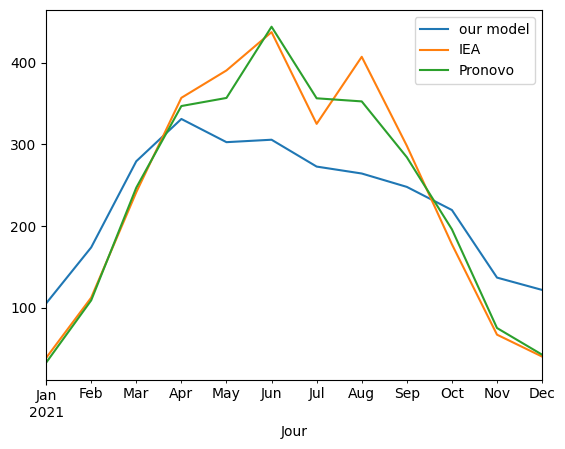

In [62]:
test2.resample('M').sum().plot()
deces['prod_iea'].plot()
pv.plot()
plt.legend(['our model', 'IEA', 'Pronovo']);

In [ ]:
solar_factor_m = solar_factor.loc['2021-01-01':'2021-12-31'].resample('M').mean().mean(axis=1)
solar_factor_m.plot()

#### v1

In [ ]:
data_monthly = by_date_c.resample('M').max().fillna(method='ffill')

In [151]:
prod_2021 = solar_factor.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00'].multiply(
    solar_plants_2021.groupby('region')['TotalPower'].sum()) / 1000

In [152]:
prod_2021.resample('M').sum().sum(axis=1)

Date
2021-01-31    162359.825804
2021-02-28    265331.575565
2021-03-31    420932.292915
2021-04-30    490329.633132
2021-05-31    441231.365354
2021-06-30    439400.553624
2021-07-31    386540.814030
2021-08-31    369762.883405
2021-09-30    342175.489343
2021-10-31    298284.025106
2021-11-30    183048.433211
2021-12-31    160117.936852
Freq: M, dtype: float64

In [153]:
prod_2021.sum(axis=1).sum()

3959514.828341633

In [108]:
2979647 * 0.9529457768508863

2839442.0251564127

In [79]:
solar_factor.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00'].describe()

,CH01,CH02,CH03,CH04,CH05,CH06,CH07
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.149968,0.134023,0.123891,0.126815,0.142125,0.136760,0.146117
std,0.216360,0.199171,0.188482,0.192550,0.206389,0.203275,0.211807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.003634,0.002744,0.002397,0.002397,0.003646,0.002849,0.003495
75%,0.270464,0.230085,0.203979,0.203999,0.248791,0.229320,0.263892
max,0.852018,0.789816,0.745777,0.755832,0.802062,0.791390,0.824157


In [84]:
solar_factor.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00'].mean().mean()

0.13709967453006863

In [89]:
solat_plants_2020 = solar_plants[solar_plants['BeginningOfOperation'] < '2021-01-01']

In [92]:
der = solar_factor.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00'].mean().multiply(
    solar_plants.groupby('region')['TotalPower'].sum())

In [98]:
der.sum() * 24 * 365 / 2

2305684260.7379065

Production estimée par région Suisse :

In [103]:
prod_2021 = solar_factor.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00'].multiply(
    solar_plants_2021.groupby('region')['TotalPower'].sum())

In [104]:
prod_2021.index = pd.to_datetime(prod_2021.index)

In [105]:
prod_2021.resample('M').sum().sum(axis=1) / 1000

Date
2021-01-31    162359.825804
2021-02-28    265331.575565
2021-03-31    420932.292915
2021-04-30    490329.633132
2021-05-31    441231.365354
2021-06-30    439400.553624
2021-07-31    386540.814030
2021-08-31    369762.883405
2021-09-30    342175.489343
2021-10-31    298284.025106
2021-11-30    183048.433211
2021-12-31    160117.936852
Freq: M, dtype: float64

In [70]:
prod_2021.sum().sum() / 1000

3959514.828341634

In [7]:
prod_per_region = solar_factor.multiply(solar_plants.groupby('region')['TotalPower'].sum(), axis=1)

In [8]:
prod_per_region

,CH01,CH02,CH03,CH04,CH05,CH06,CH07,n/a
Date,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2022-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2022-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [9]:
prod_per_region.index = pd.to_datetime(prod_per_region.index)

In [10]:
bfg = prod_per_region.resample('M').sum().sum(axis=1) / 1000

In [11]:
bfg

Date
2018-01-31    178861.620786
2018-02-28    276038.576154
2018-03-31    370064.378971
2018-04-30    535839.826672
2018-05-31    453021.599170
2018-06-30    494761.243169
2018-07-31    528784.160422
2018-08-31    454245.319991
2018-09-30    410627.445046
2018-10-31    322362.647647
2018-11-30    203949.644880
2018-12-31    158352.807178
2019-01-31    210361.294537
2019-02-28    341348.157023
2019-03-31    442267.429641
2019-04-30    454894.962378
2019-05-31    501450.533147
2019-06-30    514828.639668
2019-07-31    507434.175137
2019-08-31    465548.150392
2019-09-30    381092.579205
2019-10-31    252656.245000
2019-11-30    181748.000019
2019-12-31    167234.308094
2020-01-31    239942.345519
2020-02-29    264606.827596
2020-03-31    430653.882739
2020-04-30    562324.210262
2020-05-31    518345.755603
2020-06-30    434981.618841
2020-07-31    511614.628281
2020-08-31    454725.326669
2020-09-30    384194.936763
2020-10-31    269886.541284
2020-11-30    241919.897339
2020-12-31    1

Fichier Energy

In [25]:
solar_factor = pd.read_csv(
    './data/H_ERA5_ECMW_T639_SPV_0000m_Euro_NUT0_S197901010000_E202303312300_NRG_TIM_01h_NA-_noc_org_NA_NA---_NA---_PhM02.csv',
    skiprows=52,
    parse_dates=True,
    index_col='Date')

solar_factor = solar_factor.drop(columns=[col for col in solar_factor.columns if not col.startswith('CH')])
solar_factor.fillna(0, inplace=True)
solar_factor = solar_factor['2018-01-01 00:00:00':'2022-12-31 23:00:00']

In [31]:
solar_factor.index = pd.to_datetime(solar_factor.index)
solar_factor.resample('M').sum() / 1000

,CH
Date,
2018-01-31,111.597173
2018-02-28,169.256279
2018-03-31,223.562513
2018-04-30,314.669592
2018-05-31,268.961235
2018-06-30,292.244309
2018-07-31,310.552045
2018-08-31,265.995733
2018-09-30,241.722000


<Axes: xlabel='Date'>

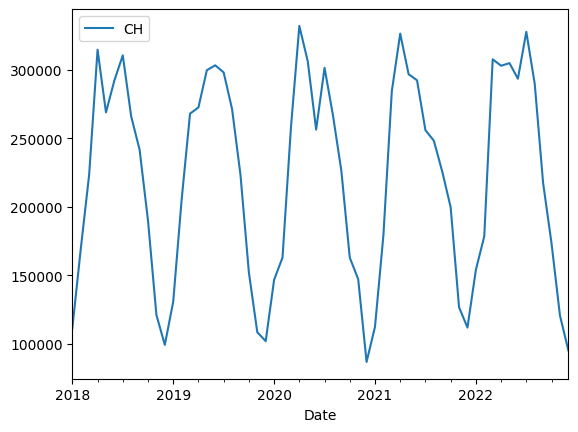

In [29]:
solar_factor.resample('M').sum().plot()

Taux de production par position géographique (Europe entière)

In [5]:
import xarray as xr

ds2 = xr.open_dataset(
    './data/H_ERA5_ECMW_T639_SPV_0000m_Euro_025d_S202101010000_E202101312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM02.nc')
solar_factor_jan_2021 = ds2.to_dataframe()

In [7]:
solar_factor_jan_2021

spv_cf
longitude latitude time                       
-22.0     72.5     2021-01-01 00:00:00     0.0
                   2021-01-01 01:00:00     0.0
                   2021-01-01 02:00:00     0.0
                   2021-01-01 03:00:00     0.0
                   2021-01-01 04:00:00     0.0
...                                        ...
 45.5     26.5     2021-01-31 19:00:00     0.0
                   2021-01-31 20:00:00     0.0
                   2021-01-31 21:00:00     0.0
                   2021-01-31 22:00:00     0.0
                   2021-01-31 23:00:00     0.0

[37300440 rows x 1 columns]

In [36]:
iea_data = {
    '2020-01-31': 83.8,
    '2020-02-29': 125.7,
    '2020-03-31': 237.9,
    '2020-04-30': 313.3,
    '2020-05-31': 338.4,
    '2020-06-30': 299.9,
    '2020-07-31': 375.3,
    '2020-08-31': 306.6,
    '2020-09-30': 254.7,
    '2020-10-31': 147.4,
    '2020-11-30': 77.1,
    '2020-12-31': 38.5,
    '2021-01-31': 38.5,
    '2021-02-28': 112.3,
    '2021-03-31': 241.3,
    '2021-04-30': 356.9,
    '2021-05-31': 390.4,
    '2021-06-30': 437.3,
    '2021-07-31': 325.0,
    '2021-08-31': 407.1,
    '2021-09-30': 298.2,
    '2021-10-31': 177.6,
    '2021-11-30': 67.0,
    '2021-12-31': 40.2,
    '2022-01-31': 97.9,
    '2022-02-28': 172.9,
    '2022-03-31': 355.7,
    '2022-04-30': 393.2,
    '2022-05-31': 484.5,
    '2022-06-30': 500.9,
    '2022-07-31': 580.8,
    '2022-08-31': 479.6,
    '2022-09-30': 337.7,
    '2022-10-31': 223.5,
    '2022-11-30': 119.1,
    '2022-12-31': 52.2,
    '2023-01-31': 94.6
}
iea_data = pd.DataFrame.from_dict(iea_data, orient='index', columns=['prod_iea'])

NameError: name 'ftg' is not defined

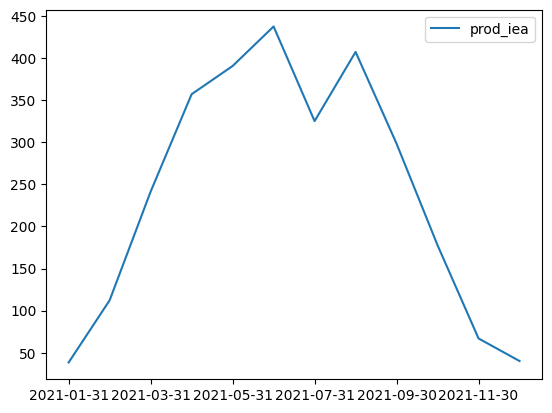

In [37]:
deces = iea_data.loc['2021-01-01':'2021-12-31']
deces.plot()
sm = ftg  #prod_2021.resample('M').sum().sum(axis=1).loc['2021-01-01':'2021-12-31']/1000
sm.index = deces.index
sm = sm
sm.plot()